Generated calibration_target.png. Print this with NO scaling at 318 DPI.


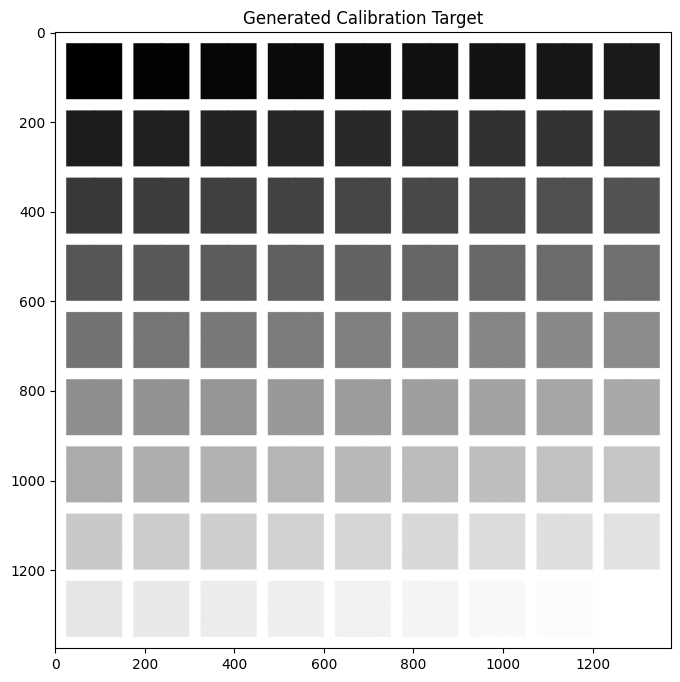

In [174]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- CONFIGURATION ---
DPI = 318
MAX_STEPS = 80  # Your hardware max power steps
PATCH_SIZE_MM = 10
GAP_MM = 2
COLUMNS = 9 
# 81 steps total (0 to 80), perfect for a 9x9 grid

def mm_to_px(mm, dpi):
    return int((mm / 25.4) * dpi)

patch_px = mm_to_px(PATCH_SIZE_MM, DPI)
gap_px = mm_to_px(GAP_MM, DPI)

# Calculate total canvas size
grid_size = patch_px + gap_px
canvas_w = grid_size * COLUMNS + gap_px
canvas_h = grid_size * COLUMNS + gap_px

# Create white canvas
canvas = np.ones((canvas_h, canvas_w), dtype=np.uint8) * 255

# Generate Patches
for step in range(MAX_STEPS + 1):
    r = step // COLUMNS
    c = step % COLUMNS
    
    y = gap_px + r * grid_size
    x = gap_px + c * grid_size
    
    # Calculate the 0-255 value the laser software expects 
    # based on your dither script logic (final_steps * 255 / max_steps)
    val = int(round(step * (255.0 / MAX_STEPS)))
    
    # Fill patch
    canvas[y : y + patch_px, x : x + patch_px] = val
    
    # Add a tiny 1-pixel "isolated dot" in the gap to measure spread
    canvas[y - 1, x + (patch_px // 2)] = val

# Save for printing
output_path = "calibration_target.png"
Image.fromarray(canvas).save(output_path, dpi=(DPI, DPI))
print(f"Generated {output_path}. Print this with NO scaling at {DPI} DPI.")

plt.figure(figsize=(8,8))
plt.imshow(canvas, cmap='gray')
plt.title("Generated Calibration Target")
plt.show()

Found 0 valid patches.
Check the 'Debug Threshold' window to see what went wrong.


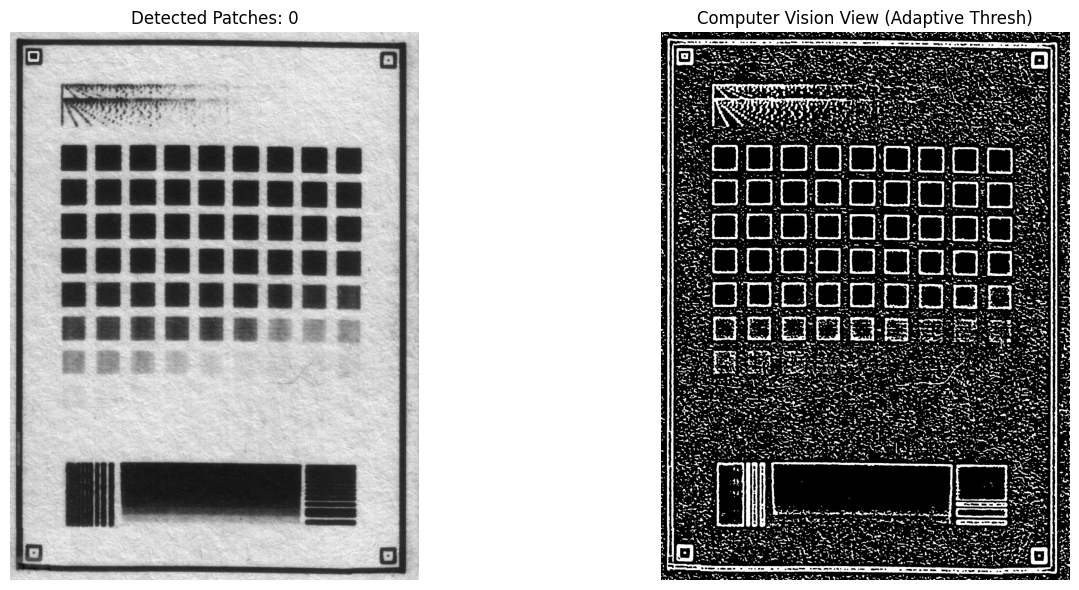

In [175]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
SCAN_PATH = "scan.png" 
SCAN_DPI = 1200 
MAX_STEPS = 80

# Minimum and Maximum expected area for a patch (in pixels)
# You might need to tweak this based on your DPI, but these are loose bounds
MIN_AREA = 30   
MAX_AREA = 100 

def sort_grid(boxes, tolerance=20):
    """
    Sorts bounding boxes into reading order (Top-Left to Bottom-Right).
    Handles slight misalignment (y-jitter) using a tolerance.
    """
    # Sort primarily by Y (top to bottom)
    boxes.sort(key=lambda b: b[1])
    
    # Group into rows based on Y tolerance
    rows = []
    current_row = [boxes[0]]
    
    for box in boxes[1:]:
        if abs(box[1] - current_row[-1][1]) < tolerance:
            current_row.append(box)
        else:
            # Sort the finished row by X (left to right)
            rows.append(sorted(current_row, key=lambda b: b[0]))
            current_row = [box]
    
    # Append last row
    rows.append(sorted(current_row, key=lambda b: b[0]))
    
    # Flatten list
    return [box for row in rows for box in row]

def find_patches_robust(img_gray):
    """
    Robustly locates patch bounding boxes using adaptive processing.
    """
    # 1. Blur to remove high-frequency paper grain
    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

    # 2. Adaptive Thresholding
    # Calculates threshold for every pixel based on its neighbors. 
    # Works perfectly even if one side of the image is brighter than the other.
    thresh = cv2.adaptiveThreshold(
        blurred, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 
        blockSize=25, # Size of neighborhood area
        C=5 # Constant subtracted from mean (tweak if grabbing too much noise)
    )

    # 3. Morphological Operations
    # "Close" operation fills small black holes inside white patches (paper texture)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
    # "Open" operation removes small white noise dots outside patches
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_OPEN, kernel, iterations=1)

    # 4. Find Contours
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    valid_boxes = []
    
    for c in contours:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        aspect_ratio = float(w) / h
        
        # 5. Geometric Filtering
        # Filter 1: Area limits (removes dust and page borders)
        if area < MIN_AREA or area > MAX_AREA:
            continue
            
        # Filter 2: Square-ish shape (allows for some rectangle stretch)
        if aspect_ratio < 0.5 or aspect_ratio > 2.0:
            continue
            
        # Filter 3: Solidity (Patch area / Bounding Box area)
        # Real patches are solid. Scribbles or dust bunnies are not.
        rect_area = w * h
        solidity = area / float(rect_area)
        if solidity < 0.8: 
            continue

        valid_boxes.append((x, y, w, h))

    # 6. Sort
    if not valid_boxes:
        return [], cleaned # Return the threshold image for debugging
        
    sorted_boxes = sort_grid(valid_boxes, tolerance=valid_boxes[0][3] // 2)
    
    return sorted_boxes, cleaned

def analyze_scan_robust(image_path):
    scan = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if scan is None: return print("File not found.")
    
    vis_img = cv2.cvtColor(scan, cv2.COLOR_GRAY2BGR)

    # --- NEW ROBUST DETECTION ---
    bounding_boxes, debug_thresh = find_patches_robust(scan)

    print(f"Found {len(bounding_boxes)} valid patches.")
    
    # Sanity Check for user
    if len(bounding_boxes) != MAX_STEPS:
        print(f"WARNING: Expected {MAX_STEPS} steps, but found {len(bounding_boxes)}.")
        print("Check the 'Debug Threshold' window to see what went wrong.")

    data = []

    for i, (x, y, w, h) in enumerate(bounding_boxes):
        if i >= MAX_STEPS: break # Stop if we found extra noise at the end

        # Drawing Visualization
        # Green = Contour detected
        cv2.rectangle(vis_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Inner sampling box (Blue)
        roi_y1, roi_y2 = y+8, y+h-8
        roi_x1, roi_x2 = x+8, x+w-8
        cv2.rectangle(vis_img, (roi_x1, roi_y1), (roi_x2, roi_y2), (255, 0, 0), 2)
        
        # Number the patches to verify sorting order
        cv2.putText(vis_img, str(i), (x + w//2 - 10, y + h//2), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        roi = scan[roi_y1:roi_y2, roi_x1:roi_x2]
        avg_intensity = np.mean(roi)
        
        # Simple Density Calculation
        measured_norm = 1.0 - (avg_intensity / 255.0) 
        data.append({ "step": i, "intensity": avg_intensity, "density": measured_norm })

    # --- PLOTTING ---
    plt.figure(figsize=(15, 6))
    
    # 1. The Visualization Map
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Patches: {len(bounding_boxes)}")
    plt.axis('off')

    # 2. The Threshold Map (Debug View)
    # This shows you exactly what the computer "sees" after processing
    plt.subplot(1, 2, 2)
    plt.imshow(debug_thresh, cmap='gray')
    plt.title("Computer Vision View (Adaptive Thresh)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(data)

# Run
df = analyze_scan_robust(SCAN_PATH)

Detected 60 patches.
Edge Bleed (10-90% Transition) at Step 20: 148.17 µm


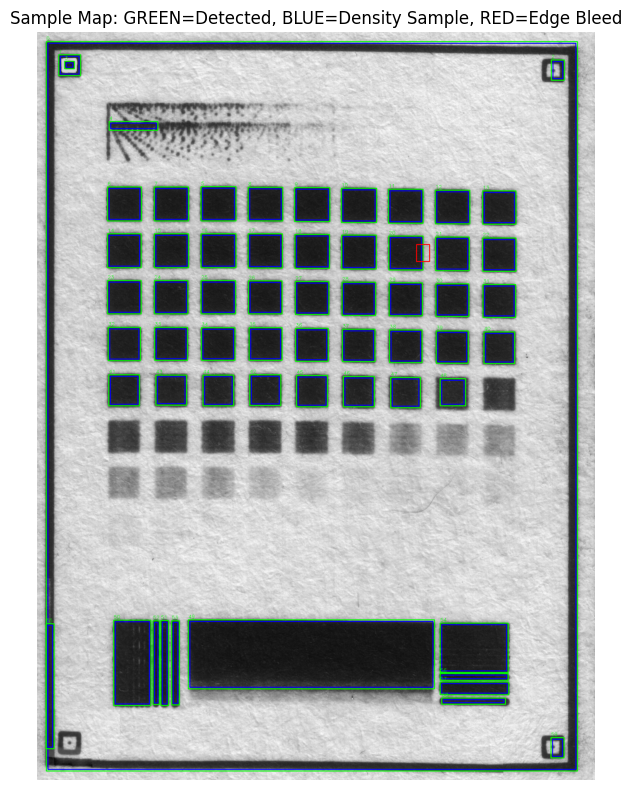

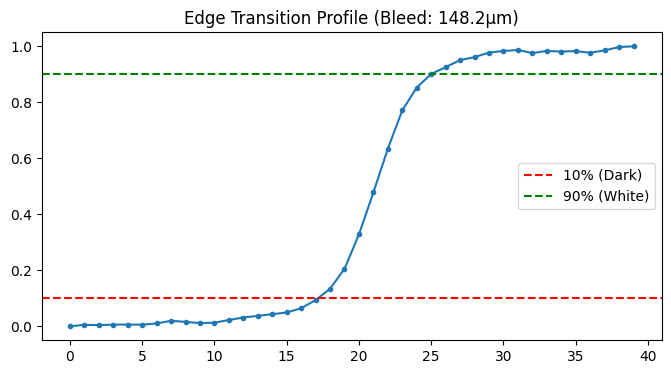

Wedge analysis saved to frequency_wedge_analysis.csv
Analysis complete.


In [176]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure

# --- CONFIGURATION ---
SCAN_PATH = "scan.png" 
SCAN_DPI = 1200 
TARGET_DPI = 318
MAX_STEPS = 80

def measure_edge_bleed(image, box, scan_dpi):
    """
    Analyzes the sharpness of the transition from a patch to white space.
    Returns bleed width in microns and the profile data.
    """
    x, y, w, h = box
    
    # Coordinates used for the slice
    # We take a 20-pixel tall strip (conceptually, though code below uses ratios)
    # The original code used h//4 to 3*h//4 (middle 50% height)
    # and w-20 to w+20 (centering on the right edge)
    
    y_start = y + (h//4)
    y_end = y + (3*h//4)
    x_start = x + w - 20
    x_end = x + w + 20
    
    # 1. Extract a slice across the right edge of the patch
    edge_zone = image[y_start : y_end, x_start : x_end]
    
    # Safety check if zone is empty (e.g., box too close to edge)
    if edge_zone.size == 0:
        return None, None

    profile = np.mean(edge_zone, axis=0) # Average vertically
    
    # 2. Normalize profile
    p_min, p_max = np.min(profile), np.max(profile)
    if p_max - p_min == 0: return None, None # Divide by zero protection
    norm_profile = (profile - p_min) / (p_max - p_min)
    
    # 3. Find 10% and 90% threshold points
    try:
        t10 = np.where(norm_profile > 0.10)[0][0]
        t90 = np.where(norm_profile > 0.90)[0][0]
        pixel_width = t90 - t10
    except IndexError:
        return None, None 

    # 4. Convert to microns
    microns = (pixel_width / scan_dpi) * 25400
    
    return microns, norm_profile

def analyze_scan(image_path):
    # Load scan
    scan = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if scan is None: 
        print("File not found.")
        return None
    
    # Create a color copy for visualization
    vis_img = cv2.cvtColor(scan, cv2.COLOR_GRAY2BGR)

    # 1. Find Patches
    _, thresh = cv2.threshold(scan, 50, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    bounding_boxes = [cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 500]
    bounding_boxes = sorted(bounding_boxes, key=lambda b: (b[1], b[0]))

    print(f"Detected {len(bounding_boxes)} patches.")

    data = []
    
    # --- LOOP AND DRAW VISUALIZATION ---
    for i, (x, y, w, h) in enumerate(bounding_boxes):
        if i > MAX_STEPS: break
        
        # 1. VISUALIZATION: Draw Green Bounding Box (Found Patch)
        cv2.rectangle(vis_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Define Sampling ROI (shrink by 5 pixels)
        roi_y1, roi_y2 = y+5, y+h-5
        roi_x1, roi_x2 = x+5, x+w-5
        
        # 2. VISUALIZATION: Draw Blue Box (Actual Density Sample Area)
        cv2.rectangle(vis_img, (roi_x1, roi_y1), (roi_x2, roi_y2), (255, 0, 0), 2)
        
        # Label the step number
        cv2.putText(vis_img, str(i), (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # Measure Intensity
        roi = scan[roi_y1:roi_y2, roi_x1:roi_x2]
        avg_intensity = np.mean(roi)
        
        theoretical_norm = i / MAX_STEPS
        measured_norm = 1.0 - (avg_intensity / 255.0) 
        
        data.append({
            "step": i,
            "input_val": int(i * 255/MAX_STEPS),
            "measured_intensity": avg_intensity,
            "density": measured_norm,
            "gain": measured_norm - theoretical_norm
        })

    df = pd.DataFrame(data)

    # --- EDGE BLEED VISUALIZATION ---
    sample_idx = MAX_STEPS // 4 
    if sample_idx < len(bounding_boxes):
        box = bounding_boxes[sample_idx]
        bx, by, bw, bh = box
        
        bleed_um, profile_data = measure_edge_bleed(scan, box, SCAN_DPI)
        
        # Calculate the coordinates used inside measure_edge_bleed for visualization
        edge_y_start = by + (bh//4)
        edge_y_end = by + (3*bh//4)
        edge_x_start = bx + bw - 20
        edge_x_end = bx + bw + 20
        
        # 3. VISUALIZATION: Draw Red Box (Edge Bleed Sample Area)
        cv2.rectangle(vis_img, (edge_x_start, edge_y_start), (edge_x_end, edge_y_end), (0, 0, 255), 2)
        
        print(f"Edge Bleed (10-90% Transition) at Step {sample_idx}: {bleed_um:.2f} µm")
    else:
        print("Not enough patches for edge bleed analysis.")
        profile_data = None

    # --- PLOT VISUALIZATION MAP ---
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
    plt.title("Sample Map: GREEN=Detected, BLUE=Density Sample, RED=Edge Bleed")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # --- PLOT PROFILE ---
    if profile_data is not None:
        plt.figure(figsize=(8, 4))
        plt.plot(profile_data, marker='o', markersize=3)
        plt.axhline(0.1, color='r', linestyle='--', label='10% (Dark)')
        plt.axhline(0.9, color='g', linestyle='--', label='90% (White)')
        plt.title(f"Edge Transition Profile (Bleed: {bleed_um:.1f}µm)")
        plt.legend()
        plt.show()

    return df, profile_data

# Run the analysis
df_results, profile_data = analyze_scan(SCAN_PATH)

if df_results is not None:
    # --- EXPORT ---
    lut_export = df_results[['input_val', 'measured_intensity']].copy()
    lut_export.to_csv("correction_lut.csv", index=False) # Uncomment to save
    profile_df = pd.DataFrame({
        'edge_profile': profile_data
    })
    profile_df.to_csv("edge_profile.csv", index=False)
    print("Wedge analysis saved to frequency_wedge_analysis.csv")
    print("Analysis complete.")

In [177]:
!pip install scikit-image


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [178]:
bleed_results = []

for i, box in enumerate(bounding_boxes):
    if i > MAX_STEPS: break
    res = measure_edge_bleed(scan, box, SCAN_DPI)
    if res:
        val_um, _ = res
        bleed_results.append({
            "step": i,
            "power_percent": (i / MAX_STEPS) * 100,
            "bleed_microns": val_um
        })

df_bleed = pd.DataFrame(bleed_results)

plt.figure(figsize=(10, 5))
plt.plot(df_bleed['power_percent'], df_bleed['bleed_microns'], 'b-o')
plt.title("Laser Power vs. Edge Bleed (Blooming)")
plt.xlabel("Laser Power (%)")
plt.ylabel("Bleed Width (µm)")
plt.grid(True)
plt.show()

NameError: name 'bounding_boxes' is not defined

File Saved: calibration_target_v8.png
Physical Size: 45.3mm x 58.5mm
Run-out area: 3mm (30px) per side


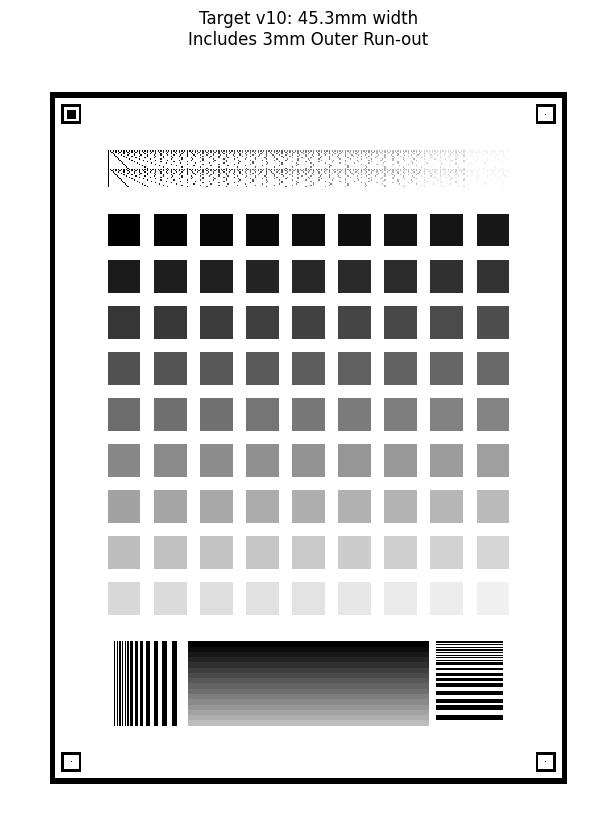

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
DPI = 254           
RUN_OUT_MM = 3      # White area outside the black border for laser lead-in/out
PATCH_SIZE = 25     
GAP_SIZE = 10       
COLUMNS = 9         
MAX_POWER_STEPS = 85 
BORDER_THICKNESS = 4
WHITE_MARGIN = 40   
FIDUCIAL_SIZE = 15  

# Calculate Run-out in pixels
RUN_OUT_PX = int(round((RUN_OUT_MM / 25.4) * DPI))

def draw_fiducial(canvas, y, x, size, solid=False):
    canvas[y:y+size, x:x+size] = 0
    canvas[y+2:y+size-2, x+2:x+size-2] = 255
    if solid:
        canvas[y+4:y+size-4, x+4:x+size-4] = 0
    else:
        canvas[y+int(size/2), x+int(size/2)] = 0

def create_stepped_power_gap_line(width, gap_px, num_steps=9):
    line = np.ones(width, dtype=np.uint8) * 255
    step_width = width / num_steps
    dot_gap = 1 + gap_px
    indices = np.arange(0, width, dot_gap)
    for idx in indices:
        zone_idx = min(int(idx // step_width), num_steps - 1)
        hw_step = zone_idx * (MAX_POWER_STEPS // (num_steps - 1))
        gray_val = int(round(hw_step * (255.0 / MAX_POWER_STEPS)))
        line[idx] = gray_val
    return line

def create_res_block_v(h, w):
    block = np.ones((h, w), dtype=np.uint8) * 255
    segment_w = w // 4
    for i, spacing in enumerate([1, 2, 3, 4]):
        start_x = i * segment_w
        for x in range(0, segment_w, spacing * 2):
            block[:, start_x + x : start_x + x + spacing] = 0
    return block

def create_res_block_h(h, w):
    block = np.ones((h, w), dtype=np.uint8) * 255
    segment_h = h // 4
    for i, spacing in enumerate([1, 2, 3, 4]):
        start_y = i * segment_h
        for y in range(0, segment_h, spacing * 2):
            block[start_y + y : start_y + y + spacing, :] = 0
    return block

# 1. CORE CONTENT GENERATION
GRID_WIDTH = (COLUMNS * PATCH_SIZE) + ((COLUMNS - 1) * GAP_SIZE)

# Top Frequency Wedge
wedge_lines = []
for gap in range(1, 15):
    for _ in range(1):
        wedge_lines.append(create_stepped_power_gap_line(GRID_WIDTH, gap))
wedge_block = np.array(wedge_lines)

# Top Frequency Wedge
wedge_2p_block = []
for gap in range(1, 15):
    for _ in range(1):
        wedge_2p_block.append(create_stepped_power_gap_line(GRID_WIDTH, gap))
wedge_2p_block = np.array(wedge_2p_block)

# Central Step Chart
grid_canvas = np.ones((GRID_WIDTH, GRID_WIDTH), dtype=np.uint8) * 255
for i in range(MAX_POWER_STEPS + 1):
    r, c = i // COLUMNS, i % COLUMNS
    y, x = r * (PATCH_SIZE + GAP_SIZE), c * (PATCH_SIZE + GAP_SIZE)
    val = int(round(i * (255.0 / MAX_POWER_STEPS)))
    grid_canvas[y:y+PATCH_SIZE, x:x+PATCH_SIZE] = val

# Density Consistency Bar (0-75% max power, 4px steps)
BAR_WIDTH = int(GRID_WIDTH * 0.6)
BAR_MAX_POWER = int(MAX_POWER_STEPS * 0.75)
NUM_DENSITY_STEPS = 16 
STEP_HEIGHT = 4
BAR_HEIGHT = NUM_DENSITY_STEPS * STEP_HEIGHT

density_layers = []
for i in range(NUM_DENSITY_STEPS):
    power_val = int((i / (NUM_DENSITY_STEPS - 1)) * BAR_MAX_POWER)
    gray_val = int(round(power_val * (255.0 / MAX_POWER_STEPS)))
    layer = np.ones((STEP_HEIGHT, BAR_WIDTH), dtype=np.uint8) * gray_val
    density_layers.append(layer)
density_bar_block = np.vstack(density_layers)

bottom_row = np.ones((BAR_HEIGHT, GRID_WIDTH), dtype=np.uint8) * 255
margin_w = (GRID_WIDTH - BAR_WIDTH) // 2
bottom_row[:, margin_w : margin_w + BAR_WIDTH] = density_bar_block
res_w = margin_w - 10
bottom_row[:, 5 : 5 + res_w] = create_res_block_v(BAR_HEIGHT, res_w)
bottom_row[:, GRID_WIDTH - res_w - 5 : GRID_WIDTH - 5] = create_res_block_h(BAR_HEIGHT, res_w)

spacer = np.ones((20, GRID_WIDTH), dtype=np.uint8) * 255
content = np.vstack([wedge_block, wedge_2p_block, spacer, grid_canvas, spacer, bottom_row])

# 2. FINAL ASSEMBLY WITH RUN-OUT
h, w = content.shape

# Padding layers: [Run Out] -> [Border] -> [White Margin]
total_h = h + (2 * WHITE_MARGIN) + (2 * BORDER_THICKNESS) + (2 * RUN_OUT_PX)
total_w = w + (2 * WHITE_MARGIN) + (2 * BORDER_THICKNESS) + (2 * RUN_OUT_PX)

final_sheet = np.ones((total_h, total_w), dtype=np.uint8) * 255 # Start with White

# Draw Black Border
b_start = RUN_OUT_PX
b_end_h = total_h - RUN_OUT_PX
b_end_w = total_w - RUN_OUT_PX
final_sheet[b_start:b_end_h, b_start:b_end_w] = 0

# Draw White Inner Margin
i_start = b_start + BORDER_THICKNESS
i_end_h = b_end_h - BORDER_THICKNESS
i_end_w = b_end_w - BORDER_THICKNESS
final_sheet[i_start:i_end_h, i_start:i_end_w] = 255

# Place Content
c_offset = i_start + WHITE_MARGIN
final_sheet[c_offset:c_offset+h, c_offset:c_offset+w] = content

# 3. ADD ASYMMETRIC FIDUCIALS
# Placed relative to the inner edge of the black border
m_pad = b_start + BORDER_THICKNESS + 5
draw_fiducial(final_sheet, m_pad, m_pad, FIDUCIAL_SIZE, solid=True)
draw_fiducial(final_sheet, m_pad, total_w - m_pad - FIDUCIAL_SIZE, FIDUCIAL_SIZE, solid=False)
draw_fiducial(final_sheet, total_h - m_pad - FIDUCIAL_SIZE, m_pad, FIDUCIAL_SIZE, solid=False)
draw_fiducial(final_sheet, total_h - m_pad - FIDUCIAL_SIZE, total_w - m_pad - FIDUCIAL_SIZE, FIDUCIAL_SIZE, solid=False)

# --- SAVE ---
img = Image.fromarray(final_sheet)
filename = "calibration_target_v8.png"
img.save(filename, dpi=(DPI, DPI))

# --- CALCULATION ---
px_h, px_w = final_sheet.shape
print(f"File Saved: {filename}")
print(f"Physical Size: {px_w/DPI*25.4:.1f}mm x {px_h/DPI*25.4:.1f}mm")
print(f"Run-out area: {RUN_OUT_MM}mm ({RUN_OUT_PX}px) per side")

# --- DISPLAY ---
plt.figure(figsize=(8, 10))
plt.imshow(final_sheet, cmap='gray', interpolation='nearest')
plt.title(f"Target v10: {px_w/DPI*25.4:.1f}mm width\nIncludes {RUN_OUT_MM}mm Outer Run-out")
plt.axis('off')
plt.show()

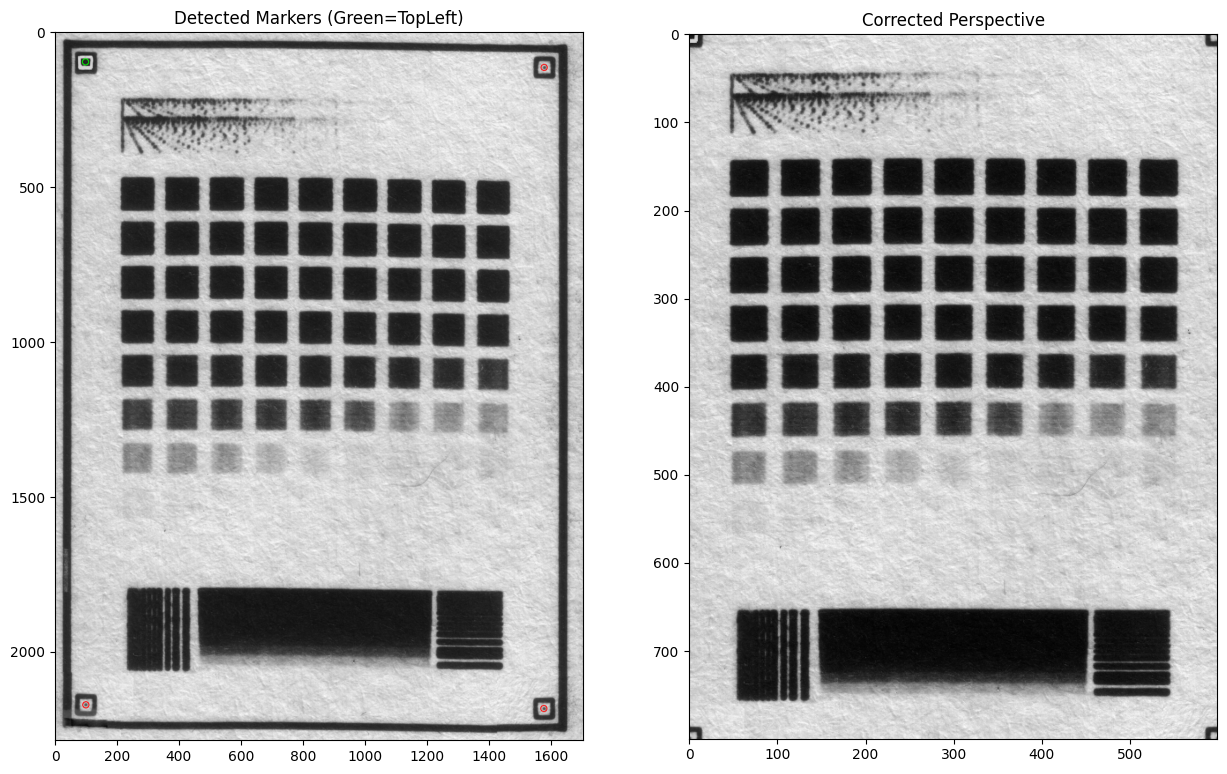

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_scan_v7(image_path, out_w=600, out_h=800):
    # 1. Load
    img = cv2.imread(image_path)
    if img is None: raise FileNotFoundError("Scan not found.")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 2. Threshold - Clean up noise
    # We want the markers to be WHITE objects on a BLACK background
    _, thresh = cv2.threshold(gray, 120, 230, cv2.THRESH_BINARY_INV)
    
    # 3. Find ALL contours (not just external)
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get image dimensions to find corner-most objects
    im_h, im_w = thresh.shape
    
    candidates = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        # Filter: Markers are small, but not microscopic (adjust based on scan res)
        if 500 < area < 2000: 
            M = cv2.moments(cnt)
            if M["m00"] == 0: continue
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            candidates.append((cx, cy))

    if len(candidates) < 4:
        # Fallback debug view
        plt.imshow(thresh, cmap='gray')
        plt.title(f"Only found {len(candidates)} small objects. Need lower threshold?")
        return None

    # 4. Find the 4 Candidates closest to the 4 corners of the image
    # This ignores the density patches in the middle
    corners = [
        (0, 0),          # Top Left
        (im_w, 0),       # Top Right
        (im_w, im_h),    # Bottom Right
        (0, im_h)        # Bottom Left
    ]
    
    final_4 = []
    for corner in corners:
        # Find candidate with minimum distance to this corner
        best_cand = min(candidates, key=lambda p: (p[0]-corner[0])**2 + (p[1]-corner[1])**2)
        final_4.append(best_cand)
    
    # 5. Determine Orientation (North Star)
    # Sample the original gray image at the center of our 4 points.
    # The Top-Left marker center is SOLID (Dark), others are HOLLOW (Light).
    intensities = []
    for (cx, cy) in final_4:
        roi = gray[cy-2:cy+3, cx-2:cx+3]
        intensities.append(np.mean(roi))
    
    # The darkest center point is our true Top-Left
    tl_idx = np.argmin(intensities)
    
    # Re-order final_4 so it starts at Top-Left and goes Clockwise
    # We use a simple roll to align the detected TL with index 0
    src_pts = np.roll(np.array(final_4, dtype="float32"), -tl_idx, axis=0)

    # 6. Perspective Warp
    dst_pts = np.array([
        [0, 0],
        [out_w - 1, 0],
        [out_w - 1, out_h - 1],
        [0, out_h - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(gray, M, (out_w, out_h))

    # Optional: Draw markers on original for debug
    debug_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    for i, p in enumerate(src_pts):
        color = (0, 255, 0) if i == 0 else (255, 0, 0) # Green for TL
        cv2.circle(debug_img, (int(p[0]), int(p[1])), 10, color, 2)
    
    return warped, debug_img

# --- EXECUTE ---
warped, debug = process_scan_v7("scan.png")

if warped is not None:
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].imshow(debug)
    ax[0].set_title("Detected Markers (Green=TopLeft)")
    ax[1].imshow(warped, cmap='gray')
    ax[1].set_title("Corrected Perspective")
    plt.show()
    
    cv2.imwrite("analysis_ready.png", warped)

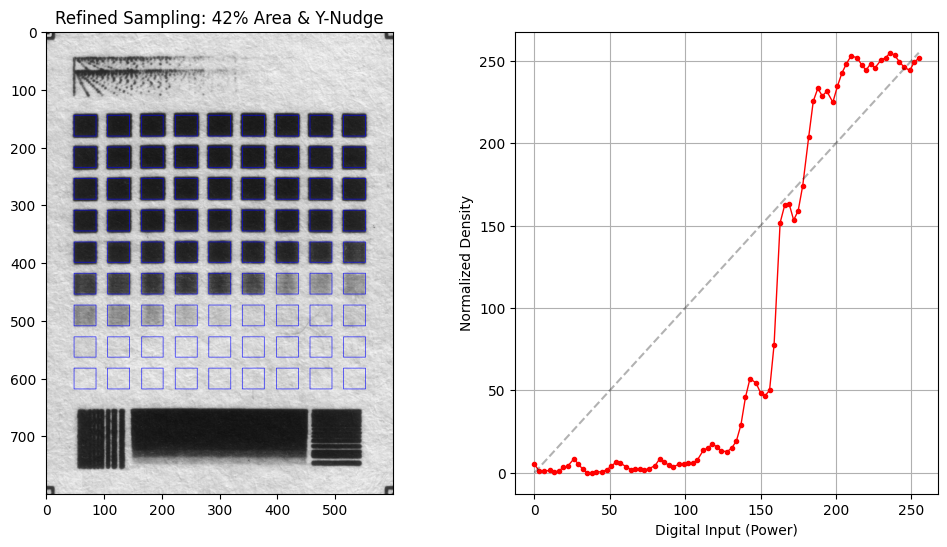

Calibration refined and saved to cyanotype_lut.csv


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- REFINED CONFIGURATION (PERCENTAGES) ---
# Nudged Y start down slightly to align with the visual center of patches
GRID_X_START = 0.064 
GRID_X_END   = 0.938  
GRID_Y_START = 0.170  # Nudged from 0.202 to 0.208
GRID_Y_END   = 0.785  # Nudged from 0.798 to 0.804

# Reduced sampling area: 0.60 * 0.70 = 0.42 (42% of total cell area)
SAMPLE_AREA_PCT = 0.42 
MAX_STEPS = 80
COLS, ROWS = 9, 9

def analyze_geometric_grid_v2(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None: raise FileNotFoundError("analysis_ready.png not found.")
    
    im_h, im_w = img.shape
    
    # Calculate pixel coordinates for the grid bounds
    x1_grid = im_w * GRID_X_START
    x2_grid = im_w * GRID_X_END
    y1_grid = im_h * GRID_Y_START
    y2_grid = im_h * GRID_Y_END
    
    grid_w = x2_grid - x1_grid
    grid_h = y2_grid - y1_grid
    
    # Calculate cell dimensions
    cell_w = grid_w / COLS
    cell_h = grid_h / ROWS
    
    # Side length multiplier (sqrt(0.42) ≈ 0.648)
    side_mult = np.sqrt(SAMPLE_AREA_PCT)
    
    results = []
    viz = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    for r in range(ROWS):
        for c in range(COLS):
            idx = r * COLS + c
            
            # Find center of this specific cell
            center_x = x1_grid + (c * cell_w) + (cell_w / 2)
            center_y = y1_grid + (r * cell_h) + (cell_h / 2)
            
            # Define smaller sampling box (now 42% area)
            sw = (cell_w * side_mult) / 2
            sh = (cell_h * side_mult) / 2
            
            sx1, sx2 = int(center_x - sw), int(center_x + sw)
            sy1, sy2 = int(center_y - sh), int(center_y + sh)
            
            # Extract and Average
            roi = img[sy1:sy2, sx1:sx2]
            if roi.size == 0: continue
            
            avg_val = np.mean(roi)
            
            results.append({
                "step": idx,
                "input_255": int(round(idx * (255.0 / MAX_STEPS))),
                "measured_raw": avg_val
            })
            
            # Draw red sampling box (now smaller and centered)
            cv2.rectangle(viz, (sx1, sy1), (sx2, sy2), (0, 0, 255), 1)

    return pd.DataFrame(results), viz

# --- EXECUTE ---
df, viz_img = analyze_geometric_grid_v2("analysis_ready.png")

# Normalization Logic
r_min, r_max = df['measured_raw'].min(), df['measured_raw'].max()
# 0 = Darkest Measured, 255 = Lightest Measured
df['normalized'] = 255 * (df['measured_raw'] - r_min) / (r_max - r_min)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(viz_img)
plt.title("Refined Sampling: 42% Area & Y-Nudge")

plt.subplot(1, 2, 2)
plt.plot(df['input_255'], df['normalized'], 'ro-', markersize=3, linewidth=1)
plt.plot([0, 255], [0, 255], 'k--', alpha=0.3)
plt.xlabel("Digital Input (Power)")
plt.ylabel("Normalized Density")
plt.grid(True)
plt.show()

# Export for dither_v2.py
df[['input_255', 'normalized']].to_csv("cyanotype_lut.csv", index=False)
print("Calibration refined and saved to cyanotype_lut.csv")

Analyzing warped image: 600x800


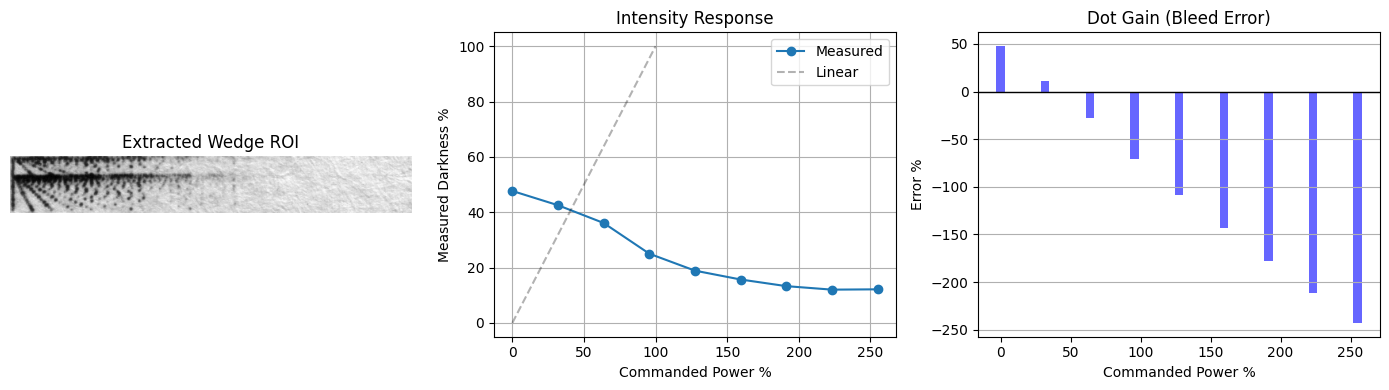

Wedge analysis saved to frequency_wedge_analysis.csv


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

def analyze_frequency_wedge(warped_img):
    # 1. Check if image exists
    if warped_img is None or warped_img.size == 0:
        print("Error: The 'warped' image is empty.")
        return

    # Ensure it's grayscale
    if len(warped_img.shape) == 3:
        warped_img = cv2.cvtColor(warped_img, cv2.COLOR_BGR2GRAY)

    h, w = warped_img.shape
    print(f"Analyzing warped image: {w}x{h}")

    # 2. DEFINE THE WEDGE ROI
    # Based on the generator: Wedge is at the top. 
    # We add safety margins to avoid the black border and white padding.
    # We expect the wedge to occupy roughly the top 12% of the internal area.
    top_margin = int(h * 0.056)    # Skip the black border/top padding
    bottom_limit = int(h * 0.145)  # Capture the wedge block
    left_margin = int(w * 0.076)   # Skip left padding
    right_margin = int(w * 0.92)
    
    wedge_roi = warped_img[top_margin:bottom_limit, left_margin:right_margin]

    # --- SAFETY CHECK ---
    if wedge_roi.size == 0:
        print(f"Error: Slice resulted in empty array. Check margins.")
        print(f"Slice Params: y{top_margin}:{bottom_limit}, x{left_margin}:{right_margin}")
        return

    # 3. MEASURE STEPS
    num_steps = 9
    roi_h, roi_w = wedge_roi.shape
    step_width = roi_w // num_steps
    
    measured_intensities = []
    expected_power = np.linspace(0, 255, num_steps)

    for i in range(num_steps):
        x_start = i * step_width
        x_end = (i + 1) * step_width
        
        # Extract vertical strip for this power step
        segment = wedge_roi[:, x_start:x_end]
        
        # --- PREVENT EMPTY MEAN ERROR ---
        if segment.size > 0:
            # Darkness calculation: (Inverted)
            darkness = 255 - np.mean(segment)
            # Normalize to 0-100%
            measured_intensities.append((darkness / 255.0) * 100)
        else:
            measured_intensities.append(0)

    measured_intensities = np.array(measured_intensities)
    
    # 4. CALC DOT GAIN
    # Dot Gain % = (Measured % - Expected %)
    dot_gain = measured_intensities - expected_power

    # 5. VISUALIZATION
    plt.figure(figsize=(14, 4))

    # Show what the computer is actually looking at
    plt.subplot(1, 3, 1)
    plt.imshow(wedge_roi, cmap='gray')
    plt.title("Extracted Wedge ROI")
    plt.axis('off')

    # Curve
    plt.subplot(1, 3, 2)
    plt.plot(expected_power, measured_intensities, 'o-', label='Measured')
    plt.plot([0, 100], [0, 100], 'k--', alpha=0.3, label='Linear')
    plt.title("Intensity Response")
    plt.xlabel("Commanded Power %")
    plt.ylabel("Measured Darkness %")
    plt.legend()
    plt.grid(True)

    # Dot Gain
    plt.subplot(1, 3, 3)
    plt.bar(expected_power, dot_gain, width=6, color='blue', alpha=0.6)
    plt.axhline(0, color='black', linewidth=1)
    plt.title("Dot Gain (Bleed Error)")
    plt.xlabel("Commanded Power %")
    plt.ylabel("Error %")
    plt.grid(True, axis='y')

    plt.tight_layout()
    plt.show()

    return expected_power, measured_intensities

# Execution (Assumes 'warped' is defined from your CV2 pipeline)
try:
    p_exp, p_meas = analyze_frequency_wedge(warped)
    # Normalization Logic
    r_min, r_max = p_meas.min(), p_meas.max()
    # 0 = Darkest Measured, 255 = Lightest Measured
    p_meas = 1 * (p_meas - r_min) / (r_max - r_min)

    # Create DataFrame from arrays and write to CSV
    wedge_df = pd.DataFrame({
        'expected_power': p_exp,
        'measured_intensity': p_meas
    })
    wedge_df.to_csv("frequency_wedge_analysis.csv", index=False)
    print("Wedge analysis saved to frequency_wedge_analysis.csv")
    
except NameError:
    print("Variable 'warped' not found. Ensure your perspective transform cell ran successfully.")